# 0. 思路说明

为简化计算, 先考虑一个公司一个股东的情况, 有两个需要模拟的方面:

模拟公司经营情况(财务数据)

模拟权益分派的情况





# 1. 部分工具

In [1]:
import platform
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

def setup_chinese_font():
    """
    自动设置matplotlib的中文字体，根据操作系统类型选择合适的字体
    """
    system = platform.system()
    
    if system == 'Windows':
        # Windows系统默认安装的中文字体
        font_family = ['Microsoft YaHei', 'SimHei']
        
    elif system == 'Darwin':  # macOS
        # macOS系统默认安装的中文字体
        font_family = ['Arial Unicode MS', 'PingFang SC', 'Heiti SC']
        
    elif system == 'Linux':
        # Linux系统常见的中文字体
        font_family = ['WenQuanYi Micro Hei', 'Noto Sans CJK SC', 'SimHei']
    
    else:
        print(f"未知操作系统类型: {system}")
        return
    
    # 遍历字体列表，使用第一个可用的字体
    font_found = False
    for font in font_family:
        try:
            # 测试字体是否可用
            plt.rcParams['font.family'] = [font]
            plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
            
            # 创建一个测试图并立即关闭，验证字体是否有效
            fig = plt.figure()
            plt.text(0.5, 0.5, '测试中文字体')
            plt.close(fig)
            
            print(f"成功设置中文字体: {font}")
            font_found = True
            break
        except Exception as e:
            continue
    
    if not font_found:
        print(f"警告：在{system}系统上未找到可用的中文字体")
        print("请手动安装中文字体后重试")


# 使用示例
setup_chinese_font()

成功设置中文字体: Arial Unicode MS


## 1.1 财务数据可视化

In [2]:
def plot_financial_data(df):
    """绘制财务数据图表（包含关键比例指标子图）"""
    import matplotlib.pyplot as plt
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    
    # 使用极简样式，避免与您的全局设置冲突
    # plt.style.use('default')  # 重置为默认样式#
    plt.rcParams.update({
        'axes.grid': True,      # 保留网格线
        'grid.alpha': 0.3,      # 网格线透明度
        'axes.titlepad': 10,    # 标题间距
        'axes.labelpad': 5      # 标签间距
    })
    
    # 创建更大的画布和更复杂的网格布局
    fig = plt.figure(figsize=(18, 16))
    fig.suptitle('财务数据分析', fontsize=16, y=1.02)
    
    # 创建子图网格 (现在有5个子图)
    gs = fig.add_gridspec(4, 2, height_ratios=[1.2, 1, 1, 1.2])
    ax1 = fig.add_subplot(gs[0, :])  # 资产负债表
    ax2 = fig.add_subplot(gs[1, 0])  # 利润表
    ax3 = fig.add_subplot(gs[1, 1])  # 现金流量表
    ax5 = fig.add_subplot(gs[2, :])  # 新增：关键比例指标
    ax4 = fig.add_subplot(gs[3, :])  # 事件时间线
    
    # 1. 资产负债表子图 (保持不变)
    balance_items = [
        '总资产', '总负债', '净资产', 
        '交易性金融资产', '衍生金融资产', '债权投资',
        '其他债权投资', '其他权益工具投资', 
        '其他非流动金融资产', '其他流动资产'
    ]
    
    line_styles = ['-', '--', '-.', ':']
    colors = plt.cm.tab10.colors
    
    for i, item in enumerate(balance_items):
        ax1.plot(df['财务数据日期'], df[item], 
                label=item, 
                linestyle=line_styles[i % len(line_styles)],
                color=colors[i % len(colors)],
                linewidth=1.5,
                markersize=4)
    
    ax1.set_title('资产负债表项目趋势')
    ax1.set_ylabel('金额')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(True, linestyle=':', alpha=0.6)
    
    # 创建右侧坐标轴
    ax2_secondary = ax2.twinx()
    
    # 左侧坐标轴：净利润系列
    income_items = ['净利润', '母公司报表净利润']
    colors_left = ['#1f77b4', '#ff7f0e']  # 保持原有颜色方案
    for i, item in enumerate(income_items):
        ax2.plot(df['财务数据日期'], df[item], 
                label=item, 
                color=colors_left[i],
                linewidth=2,
                marker='o',
                markersize=5)
    
    # 右侧坐标轴：营业收入
    color_right = '#2ca02c'  # 使用对比色
    ax2_secondary.plot(df['财务数据日期'], df['营业收入'], 
                     label='营业收入',
                     color=color_right,
                     linewidth=2,
                     linestyle='--',
                     marker='s',
                     markersize=5)
    
    # 设置坐标轴标签
    ax2.set_ylabel('净利润（万元）', color=colors_left[0])
    ax2_secondary.set_ylabel('营业收入（万元）', color=color_right)
    
    # 设置坐标轴颜色
    ax2.tick_params(axis='y', colors=colors_left[0])
    ax2_secondary.tick_params(axis='y', colors=color_right)
    
    # 合并图例
    lines_left, labels_left = ax2.get_legend_handles_labels()
    lines_right, labels_right = ax2_secondary.get_legend_handles_labels()
    ax2.legend(lines_left + lines_right, labels_left + labels_right, loc='upper left')
    
    ax2.set_title('利润表项目趋势（含营业收入）')
    ax2.grid(True, linestyle=':', alpha=0.6)

    # 保留净利润正负标记（保持不变）
    for i, val in enumerate(df['净利润']):
        color = 'green' if val >= 0 else 'red'
        ax2.axvline(x=df['财务数据日期'][i], color=color, alpha=0.2, linewidth=3)
    
    # 3. 现金流量表子图 (保持不变)
    cash_items = ['经营活动现金流量净额']
    for item in cash_items:
        ax3.plot(df['财务数据日期'], df[item], 
                label=item, 
                color='#9467bd',
                linewidth=2,
                marker='s',
                markersize=5)
    
    ax3.set_title('现金流量表项目趋势')
    ax3.set_ylabel('金额')
    ax3.legend()
    ax3.grid(True, linestyle=':', alpha=0.6)
    
    # 4. 新增：关键比例指标子图
    ratio_items = [
        ('资产负债率', '#d62728', '%-'),
        ('净资产增长率', '#2ca02c', '%-'),
        ('净利润增长率', '#1f77b4', '%-'),
        ('经营活动现金流增长率', '#ff7f0e', '%-'),
        ('金融资产增长率', '#9467bd', '%-')
    ]
    
    # 创建双坐标轴
    ax5_secondary = ax5.twinx()
    
    # 主坐标轴 (资产负债率)
    ax5.plot(df['财务数据日期'], df['资产负债率']*100, 
            label='资产负债率', 
            color='#d62728',
            linewidth=2.5,
            marker='^',
            markersize=6)
    ax5.set_ylabel('资产负债率 (%)', color='#d62728')
    ax5.tick_params(axis='y', colors='#d62728')
    ax5.set_ylim(0, df['资产负债率'].max()*100*1.1)
    
    # 次坐标轴 (增长率指标)
    for i, (item, color, fmt) in enumerate(ratio_items[1:]):
        ax5_secondary.plot(df['财务数据日期'], df[item]*100, 
                         label=item,
                         color=color,
                         linewidth=2,
                         linestyle='--' if i%2==0 else '-',
                         alpha=0.8)
    
    ax5_secondary.set_ylabel('增长率 (%)', color='#1f77b4')
    ax5_secondary.tick_params(axis='y', colors='#1f77b4')
    
    # 合并图例
    lines, labels = ax5.get_legend_handles_labels()
    lines2, labels2 = ax5_secondary.get_legend_handles_labels()
    ax5.legend(lines + lines2, labels + labels2, loc='upper left')
    
    ax5.set_title('关键财务比例与增长率指标')
    ax5.grid(True, linestyle=':', alpha=0.6)
    
    # 5. 事件时间线子图 (保持不变)
    ax4.set_title('关键事件时间线')
    ax4.set_yticks([])
    ax4.set_xlim(df['财务数据日期'].min(), df['财务数据日期'].max())
    
    # 绘制报告发布事件
    for i, row in df.iterrows():
        if pd.notna(row['公告类型']):
            # 报告类型标记
            report_marker = '^' if row['公告类型'] == '年报' else 'o'
            report_color = 'blue' if row['公告类型'] == '年报' else 'lightblue'
            ax4.scatter(row['财务数据日期'], 0.3, 
                       marker=report_marker, 
                       color=report_color, 
                       s=100,
                       edgecolor='black',
                       linewidth=0.5)
            
            # 审计意见标记
            if pd.notna(row['审计意见']):
                audit_y = 0.6
                audit_color = {
                    '无保留意见': 'green',
                    '非标准无保留意见': 'orange',
                    '保留意见': 'red'
                }.get(row['审计意见'], 'gray')
                ax4.scatter(row['财务数据日期'], audit_y, 
                           marker='*', 
                           color=audit_color, 
                           s=150,
                           edgecolor='black',
                           linewidth=0.5)
    
    # 绘制净利润正负标记
    for i, row in df.iterrows():
        profit_color = 'green' if row['净利润'] >= 0 else 'red'
        ax4.scatter(row['财务数据日期'], 0, 
                   color=profit_color, 
                   alpha=0.5,
                   s=30,
                   edgecolor='black',
                   linewidth=0.3)
    
    # 添加图例
    legend_elements = [
        Line2D([0], [0], marker='^', color='w', label='年报发布', 
               markerfacecolor='blue', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='季报发布', 
               markerfacecolor='lightblue', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='*', color='w', label='标准无保留意见', 
               markerfacecolor='green', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='*', color='w', label='保留意见', 
               markerfacecolor='orange', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='*', color='w', label='非标准无保留意见', 
               markerfacecolor='red', markersize=10, markeredgecolor='black'),
        Patch(facecolor='green', alpha=0.5, label='净利润为正'),
        Patch(facecolor='red', alpha=0.5, label='净利润为负')
    ]
    
    ax4.legend(handles=legend_elements, loc='upper right', framealpha=0.9)
    
    plt.tight_layout()
    return fig

# 2. 单个公司数据生成

## 1.1 财务数据生成

In [3]:
import pandas as pd
import numpy as np

DEFAULT_FINANCIAL_CONFIG = {
    # 时间范围配置
    "date_range": {
        "start_date": "2018-01-01",
        "end_date": "2024-12-31",
        "freq": "QE-DEC"  # 季度末日期
    },

    # 审计意见概率配置
    "audit_opinion": {
        "无保留意见": 0.8,       # 无保留意见概率
        "保留意见": 0.1,        # 保留意见概率
        "非标准无保留意见": 0.1      # 非标准无保留意见概率
    },

    # 财务初始值配置
    "initial_values": {
        "net_assets": 180_000_000,    # 初始净资产
        "net_profit": 18_000_000,     # 初始净利润
        "total_shares": 40_000_000,   # 总股本
        "profit_adjustment": -17_000_000,  # 净利润调整值
        "parent_net_profit_ratio": 0.9,    # 母公司净利润占合并净利润比例
        "retained_earnings_ratio": 0.7,    # 未分配利润占净利润比例
        "asset_liability_ratio": 0.3,      # 初始资产负债率
        "financial_assets_ratio": (0.1, 0.3),  # 金融资产占总资产比例范围
        "revenue_multiplier_range": (0.5, 5.0),  # 新增：营业收入乘数范围（净利润绝对值的倍数）
        "revenue_zero_prob": 0.03,  # 新增：营业收入为0的概率（5%）
    },
    
    # 增长率配置
    "growth_rates": {
        "net_assets": {"mean": 0.03, "std": 0.09},
        "net_profit": {"mean": 0.05, "std": 0.4},
        "asset_liability": {"mean": 0.01, "std": 0.05},
        "financial_assets": {"mean": 0.03, "std": 0.08}
    },

    # 现金流生成配置
    "cash_flow_ranges": {
        "operating_cash_flow": (-0.2, 1.2),  # 经营活动现金流/净利润比率范围
        "investment_cash_flow": (-0.2, 0.1),  # 投资活动现金流/总资产比率范围
        "financing_cash_flow": (-0.2, 0.5)  # 筹资活动现金流/总资产比率范围
    },
    
    # 金融资产分配比例范围
    "financial_assets_ranges": {
        "trading_financial_assets": (0.15, 0.35),      # 交易性金融资产
        "derivative_financial_assets": (0.01, 0.1),    # 衍生金融资产
        "debt_investments": (0.1, 0.25),              # 债权投资
        "other_debt_investments": (0.05, 0.2),        # 其他债权投资
        "other_equity_investments": (0.05, 0.15),     # 其他权益工具投资
        "other_noncurrent_financial_assets": (0.1, 0.25),  # 其他非流动金融资产
        "other_current_assets": (0.05, 0.15)          # 其他流动资产(金融类)
    },
    
    # 验证条件配置
    "validation": {
        "max_profit_asset_ratio": 0.3,          # 净利润/净资产最大比率
        "max_consecutive_loss_years": 3,        # 最大连续亏损年数
        "max_asset_growth_multiple": 5,         # 净资产最大增长倍数
        "min_loss_quarters": 2,                 # 最小亏损季度数
        "max_asset_liability_ratio": 0.9,       # 最大资产负债率
        "min_asset_liability_ratio": 0.2,       # 最小资产负债率
        "min_financial_assets_ratio": 0.05,     # 金融资产最小占比
        "max_financial_assets_ratio": 0.4       # 金融资产最大占比
    }
}

class FinancialDataGenerator:
    def __init__(self, config=None):
        """初始化财务数据生成器"""
        self.config = config or DEFAULT_FINANCIAL_CONFIG
        self._process_config()
        
    def _process_config(self):
        """预处理配置参数"""
        # 生成季度日期序列
        date_cfg = self.config["date_range"]
        self.all_quarters = pd.date_range(
            start=date_cfg["start_date"],
            end=date_cfg["end_date"],
            freq=date_cfg["freq"]
        )
        self.num_quarters = len(self.all_quarters)
        
    def generate(self, max_retries=1000):
        """
        生成符合要求的财务数据
        参数:
            max_retries: 最大尝试次数
        返回:
            生成的财务数据DataFrame
        """
        for _ in range(max_retries):
            df = self._generate_base_data()
            df = self._calculate_derived_fields(df)
            if self._validate_data(df):
                df.rename(columns={"日期": "财务数据日期"}, inplace=True)
                return self._reorder_columns(df)
        raise ValueError("无法生成符合条件的数据，请调整配置参数")

    def _generate_base_data(self):
        """生成基础增长率数据"""
        growth = self.config["growth_rates"]
        return pd.DataFrame({
            "日期": self.all_quarters,
            "净资产增长率": np.random.normal(
                growth["net_assets"]["mean"],
                growth["net_assets"]["std"],
                self.num_quarters
            ),
            "净利润增长率": np.random.normal(
                growth["net_profit"]["mean"],
                growth["net_profit"]["std"],
                self.num_quarters
            ),
            "资产负债率变化": np.random.normal(
                growth["asset_liability"]["mean"],
                growth["asset_liability"]["std"],
                self.num_quarters
            ),
            "金融资产增长率": np.random.normal(
                growth["financial_assets"]["mean"],
                growth["financial_assets"]["std"],
                self.num_quarters
            )
        })

    def _calculate_derived_fields(self, df):
        """计算所有衍生财务指标"""
        init = self.config["initial_values"]
        
        # 1. 计算基本财务指标
        df["净资产"] = init["net_assets"] * (1 + df["净资产增长率"]).cumprod()
        df["净利润"] = init["net_profit"] * (1 + df["净利润增长率"]).cumprod() + init["profit_adjustment"]

        # 1.1 计算营业收入（净利润绝对值的随机倍数）
        is_zero = np.random.rand(len(df)) < init["revenue_zero_prob"]
        multiplier_min, multiplier_max = init["revenue_multiplier_range"]
        base_revenue = np.abs(df["净利润"]) * np.random.uniform(
            init["revenue_multiplier_range"][0],
            init["revenue_multiplier_range"][1],
            len(df)
        )
        df["营业收入"] = np.where(is_zero, 0, base_revenue) # 这个设定是因为有的检查单元的规则要如此触发
        
        # 2. 计算资产负债相关指标
        df["资产负债率"] = np.clip(
            init["asset_liability_ratio"] + df["资产负债率变化"].cumsum(),
            self.config["validation"]["min_asset_liability_ratio"],
            self.config["validation"]["max_asset_liability_ratio"]
        )
        df["总负债"] = df["净资产"] * df["资产负债率"] / (1 - df["资产负债率"])
        df["总资产"] = df["净资产"] + df["总负债"]
        
        # 3. 计算每股指标
        df["总股本"] = init["total_shares"]
        df["每股净资产"] = df["净资产"] / df["总股本"]
        df["每股净利润"] = df["净利润"] / df["总股本"]
        
        # 4. 计算母公司报表数据
        df["母公司报表净利润"] = df["净利润"] * init["parent_net_profit_ratio"] * (1 + np.random.normal(0, 0.05, len(df)))
        df["合并报表未分配利润"] = df["净利润"].cumsum() * init["retained_earnings_ratio"]
        df["母公司报表未分配利润"] = df["母公司报表净利润"].cumsum() * init["retained_earnings_ratio"]
        
        # 5. 生成随机金融资产分配
        self._generate_financial_assets(df)
        
        # 6. 生成随机现金流数据
        self._generate_cash_flows(df)
        
        # 7. 添加报告相关信息
        self._add_report_info(df)
        
        return df

    def _generate_financial_assets(self, df):
        """随机生成各类金融资产数据"""
        # 中英文列名映射
        name_mapping = {
            "trading_financial_assets": "交易性金融资产",
            "derivative_financial_assets": "衍生金融资产",
            "debt_investments": "债权投资",
            "other_debt_investments": "其他债权投资",
            "other_equity_investments": "其他权益工具投资",
            "other_noncurrent_financial_assets": "其他非流动金融资产",
            "other_current_assets": "其他流动资产"
        }
        
        # 随机确定金融资产占总资产比例
        fin_ratio = np.random.uniform(*self.config["initial_values"]["financial_assets_ratio"])
        df["金融资产总额"] = df["总资产"] * fin_ratio * (1 + np.random.normal(0, 0.05, len(df)))
        
        # 随机分配各类金融资产比例
        items = list(self.config["financial_assets_ranges"].keys())
        ratios = np.random.dirichlet(
            [np.random.uniform(*self.config["financial_assets_ranges"][item]) for item in items]
        )
        
        # 计算各类金融资产金额并使用中文列名
        for i, item in enumerate(items):
            df[name_mapping[item]] = df["金融资产总额"] * ratios[i] * (1 + np.random.normal(0, 0.05, len(df)))
        
        # 删除临时的英文列名（如果有）
        for item in items:
            if item in df.columns:
                df.drop(item, axis=1, inplace=True)
        
        return df

    def _generate_cash_flows(self, df):
        """随机生成三类现金流数据"""
        cfg = self.config["cash_flow_ranges"]
        
        # 经营活动现金流（改为完全随机生成，不依赖净利润）
        # 使用总资产作为基数乘以随机比例，确保规模合理
        operating_ratio = np.random.uniform(*cfg["operating_cash_flow"])
        df["经营活动现金流量净额"] = df["总资产"] * np.random.uniform(0.01, 0.2, len(df)) * (1 if np.random.rand() > 0.5 else -1)
        
        # 投资活动现金流（与总资产相关）
        investment_ratio = np.random.uniform(*cfg["investment_cash_flow"])
        df["投资活动现金流量净额"] = df["总资产"] * investment_ratio * (1 + np.random.normal(0, 0.05, len(df)))
        
        # 筹资活动现金流（与总资产相关）
        financing_ratio = np.random.uniform(*cfg["financing_cash_flow"])
        df["筹资活动现金流量净额"] = df["总资产"] * financing_ratio * (1 + np.random.normal(0, 0.05, len(df)))
        
        # 计算现金净增加额
        df["现金及现金等价物净增加额"] = (
            df["经营活动现金流量净额"] + 
            df["投资活动现金流量净额"] + 
            df["筹资活动现金流量净额"]
        )

    def _add_report_info(self, df):
        """添加报告类型、公告日期和审计意见等信息"""
        # 报告类型
        df["公告类型"] = df["日期"].apply(self._get_report_type)
        
        # 公告日期
        df["公告日期"] = df["日期"].apply(self._get_announcement_date)
        
        # # 复权因子
        # df["复权因子"] = 1
        
        # 审计意见 (只在年报时生成)
        audit_probs = self.config["audit_opinion"]
        audit_choices = list(audit_probs.keys())
        audit_probs = list(audit_probs.values())
        
        df["审计意见"] = df["公告类型"].apply(
            lambda x: np.random.choice(audit_choices, p=audit_probs) # if x == "年报" else None
        )

    def _get_report_type(self, date):
        """根据日期确定报告类型"""
        fmt_date = date.strftime("%m-%d")
        return {
            "03-31": "季报",
            "06-30": "半年报",
            "09-30": "季报",
            "12-31": "年报"
        }.get(fmt_date, None)

    def _get_announcement_date(self, date):
        """根据报告期计算公告日期"""
        year = date.year
        month_day = date.strftime("%m-%d")
        
        if month_day == "06-30":
            return pd.Timestamp(f"{year}-08-27")  # 半年报公告日期
        if month_day == "12-31":
            return pd.Timestamp(f"{year+1}-03-30") # 年报公告日期
        if month_day == "03-31":
            return pd.Timestamp(f"{year}-04-30") # 一季报公告日期
        if month_day == "09-30":
            return pd.Timestamp(f"{year}-10-27") # 三季报公告日期
        return None

    def _validate_data(self, df):
        """验证生成的数据是否符合业务规则"""
        val_cfg = self.config["validation"]
        
        conditions = [
            # 净利润/净资产比率限制
            (df["净利润"] / df["净资产"] <= val_cfg["max_profit_asset_ratio"]).all(),
            
            # 连续亏损年数限制
            self._check_consecutive_loss(df),
            
            # 净资产增长倍数限制
            (df["净资产"].iloc[-1] / df["净资产"].iloc[0] <= val_cfg["max_asset_growth_multiple"]),
            
            # 最小亏损季度数
            (df["净利润"] < 0).sum() >= val_cfg["min_loss_quarters"],
            
            # 资产负债率范围验证
            df["资产负债率"].between(
                val_cfg["min_asset_liability_ratio"],
                val_cfg["max_asset_liability_ratio"]
            ).all(),
            
            # 金融资产占比验证
            df["金融资产总额"].div(df["总资产"]).between(
                val_cfg["min_financial_assets_ratio"],
                val_cfg["max_financial_assets_ratio"]
            ).all()
        ]
        
        return all(conditions)
    
    def _check_consecutive_loss(self, df):
        """检查连续亏损年数是否符合要求"""
        annual_profit = df.set_index("日期")["净利润"].resample("YE").sum()
        consecutive_loss = (annual_profit < 0).astype(int).groupby((annual_profit >= 0).cumsum()).cumsum()
        return (consecutive_loss <= self.config["validation"]["max_consecutive_loss_years"]).all()

    def _reorder_columns(self, df):
        """调整列顺序，使报表更易读"""
        # 定义各报表的列顺序
        report_info = ["财务数据日期", "公告类型", "公告日期", "复权因子", "审计意见"]
        
        balance_sheet = [
            "总资产", "总负债", "净资产", "资产负债率",
            "交易性金融资产", "衍生金融资产", "债权投资", "其他债权投资",
            "其他权益工具投资", "其他非流动金融资产", "其他流动资产",
            "金融资产总额", "总股本", "每股净资产",
            "合并报表未分配利润", "母公司报表未分配利润"
        ]
        
        income_statement = [
            "营业收入", "净利润", "每股净利润", "母公司报表净利润"
        ]
        
        cash_flow = [
            "经营活动现金流量净额", "投资活动现金流量净额",
            "筹资活动现金流量净额", "现金及现金等价物净增加额"
        ]
        
        growth_rates = [
            "净资产增长率", "净利润增长率", "资产负债率变化", "金融资产增长率"
        ]
        
        # 合并所有列并保留原始数据中可能存在的其他列
        ordered_columns = report_info + balance_sheet + income_statement + cash_flow + growth_rates
        existing_columns = [col for col in ordered_columns if col in df.columns]
        extra_columns = [col for col in df.columns if col not in existing_columns]
        
        return df[existing_columns + extra_columns]



generator = FinancialDataGenerator()
financial_data = generator.generate()
financial_data

,财务数据日期,公告类型,公告日期,审计意见,总资产,总负债,净资产,资产负债率,交易性金融资产,衍生金融资产,...,每股净利润,母公司报表净利润,经营活动现金流量净额,投资活动现金流量净额,筹资活动现金流量净额,现金及现金等价物净增加额,净资产增长率,净利润增长率,资产负债率变化,金融资产增长率
0,2018-03-31,季报,2018-04-30,非标准无保留意见,2.115039e+08,4.478572e+07,1.667182e+08,0.211749,1.313481e+07,1.001234e+06,...,0.056806,2.025299e+06,-1.784226e+07,-7.413849e+06,3.167107e+07,6.414957e+06,-0.073788,0.070681,-0.088251,0.063042
1,2018-06-30,半年报,2018-08-27,无保留意见,2.179664e+08,4.362235e+07,1.743440e+08,0.200133,1.490379e+07,1.100976e+06,...,0.053915,1.909568e+06,-3.450168e+07,-7.093766e+06,3.134605e+07,-1.024939e+07,0.045741,-0.006002,-0.011616,0.110726
2,2018-09-30,季报,2018-10-27,无保留意见,2.313678e+08,4.627357e+07,1.850943e+08,0.200000,1.472681e+07,1.049165e+06,...,0.089088,3.252651e+06,-3.910560e+07,-7.674242e+06,3.559800e+07,-1.118184e+07,0.061661,0.073445,-0.013031,-0.064084
3,2018-12-31,年报,2019-03-30,无保留意见,3.022251e+08,8.097446e+07,2.212506e+08,0.267928,1.813098e+07,1.387081e+06,...,0.009139,2.789900e+05,-5.427995e+07,-9.830779e+06,4.339186e+07,-2.071887e+07,0.195340,-0.155517,0.080825,0.160524
4,2019-03-31,季报,2019-04-30,无保留意见,3.704014e+08,1.260851e+08,2.443164e+08,0.340401,2.650292e+07,1.927806e+06,...,-0.228073,-8.017984e+06,-2.660498e+07,-1.143889e+07,4.939731e+07,1.135343e+07,0.104252,-0.546397,0.072474,0.039193
5,2019-06-30,半年报,2019-08-27,无保留意见,3.848532e+08,1.283139e+08,2.565393e+08,0.333410,2.412017e+07,1.880226e+06,...,-0.244984,-8.054968e+06,-4.258530e+07,-1.265636e+07,5.920410e+07,3.962445e+06,0.050029,-0.085871,-0.006991,-0.010873
6,2019-09-30,季报,2019-10-27,保留意见,4.139185e+08,1.586109e+08,2.553076e+08,0.383194,2.803199e+07,2.103291e+06,...,-0.305130,-1.206590e+07,-7.232904e+07,-1.511247e+07,6.326884e+07,-2.417267e+07,-0.004801,-0.334119,0.049784,-0.082748
7,2019-12-31,年报,2020-03-30,保留意见,3.500968e+08,1.298318e+08,2.202650e+08,0.370846,2.226421e+07,1.702543e+06,...,-0.337928,-1.219105e+07,-5.872238e+07,-1.272627e+07,5.283309e+07,-1.861556e+07,-0.137256,-0.273612,-0.012348,-0.010211
8,2020-03-31,季报,2020-04-30,无保留意见,3.815249e+08,1.460195e+08,2.355055e+08,0.382726,2.404119e+07,1.712969e+06,...,-0.250433,-9.294407e+06,-3.997286e+07,-1.244411e+07,5.305877e+07,6.417980e+05,0.069192,1.004865,0.011880,0.062270
9,2020-06-30,半年报,2020-08-27,无保留意见,4.223997e+08,1.547210e+08,2.676788e+08,0.366290,2.736647e+07,2.317723e+06,...,-0.226692,-8.290890e+06,-6.476148e+06,-1.345233e+07,5.822761e+07,3.829913e+07,0.136614,0.135996,-0.016436,0.145326


In [4]:
financial_data.columns

Index(['财务数据日期', '公告类型', '公告日期', '审计意见', '总资产', '总负债', '净资产', '资产负债率',
       '交易性金融资产', '衍生金融资产', '债权投资', '其他债权投资', '其他权益工具投资', '其他非流动金融资产',
       '其他流动资产', '金融资产总额', '总股本', '每股净资产', '合并报表未分配利润', '母公司报表未分配利润', '营业收入',
       '净利润', '每股净利润', '母公司报表净利润', '经营活动现金流量净额', '投资活动现金流量净额', '筹资活动现金流量净额',
       '现金及现金等价物净增加额', '净资产增长率', '净利润增长率', '资产负债率变化', '金融资产增长率'],
      dtype='object')

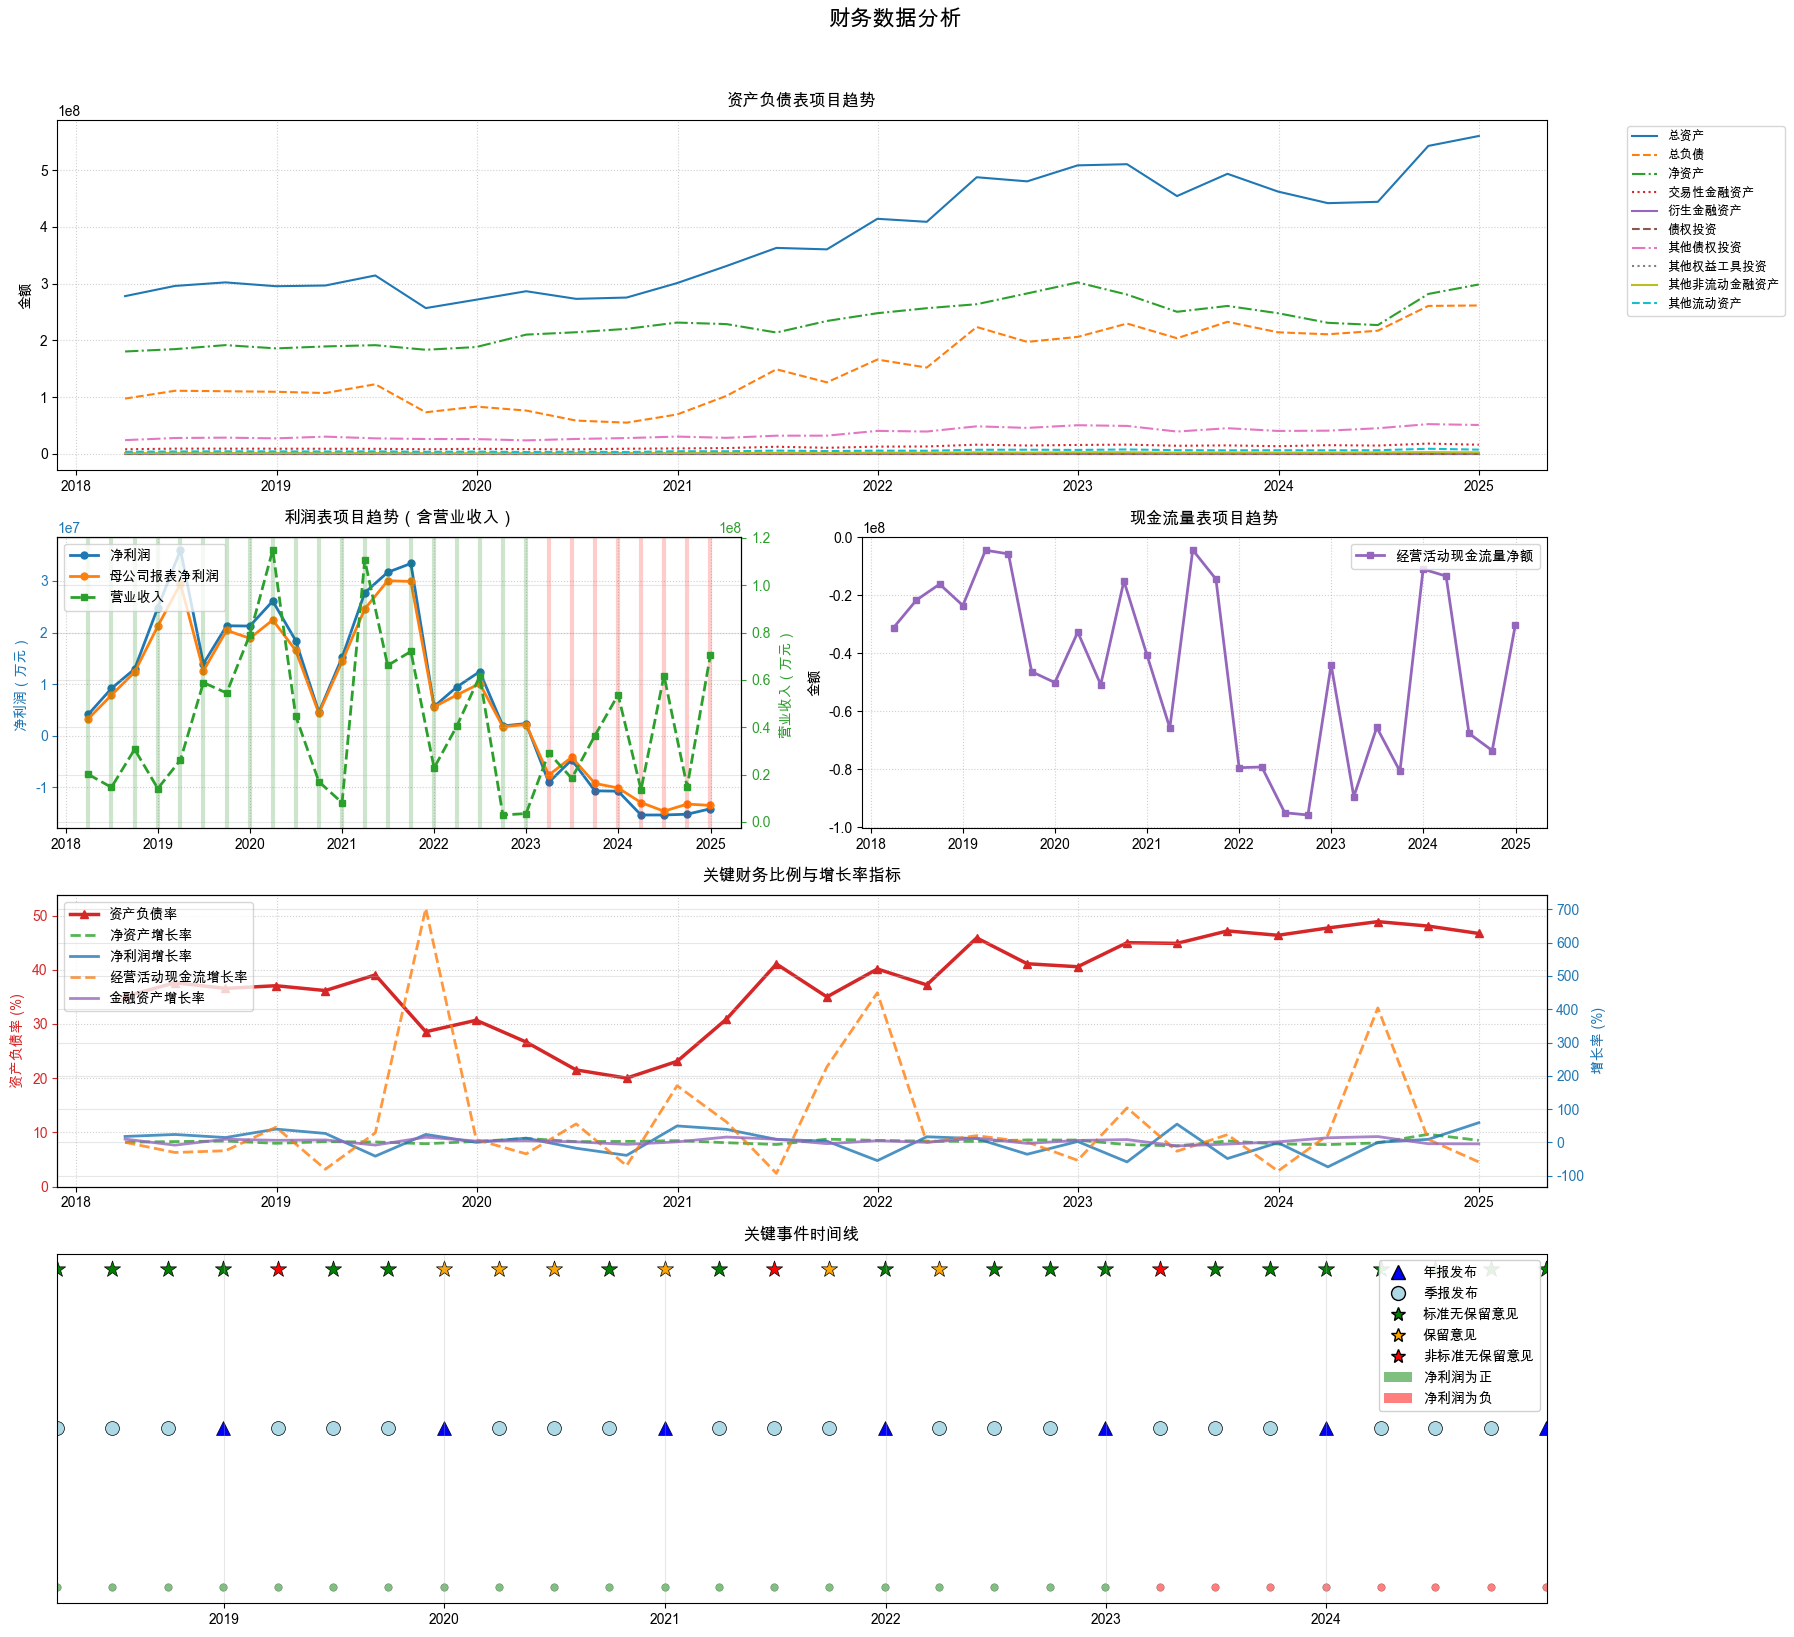

In [5]:
# 生成数据
generator = FinancialDataGenerator()
financial_data = generator.generate()
financial_data['经营活动现金流增长率'] = financial_data['经营活动现金流量净额'].pct_change()
financial_data.loc[0, '经营活动现金流增长率'] = 0

# 绘制图表
fig = plot_financial_data(financial_data)
plt.show()

## 1.2 分红行为数据

In [6]:
import pandas as pd
import numpy as np
from datetime import timedelta

# ========================
# 配置字典（可自由调整参数）
# ========================
config = {
    # 现金分红相关配置
    'cash_dividend_prob': 0.3,          # 实施现金分红的概率
    'cash_ratio_range': (0.1, 1.5),     # 现金分红比例范围（相对于净利润）
    
    # 股票股利相关配置
    'stock_dividend_prob': 0.2,         # 实施股票股利的概率
    'stock_ratio_range': (0, 5),        # 送股比例范围（每10股送X股）
    
    # 公积金转增股本配置
    'surplus_reserve_prob': 0.15,       # 实施转增股的概率
    'surplus_ratio_range': (0, 10),     # 转增比例范围（每10股转增X股）
    
    # 时间相关配置
    'min_days_after_announcement': 10,  # 权益分派日期在公告日期后的最小天数
    'max_days_after_announcement': 60,  # 权益分派日期在公告日期后的最大天数
    
    # 股东减持相关配置
    'past_reduction_prob': 0.25,       # 前三个月内存在减持情形的概率
    'future_reduction_prob': 0.2       # 后三个月存在减持计划的概率
}

# ========================
# 核心处理函数
# ========================
def generate_equity_events(financial_data, config):
    # 深拷贝原始数据避免污染
    df = financial_data.copy()
    
    # 初始化权益分派相关列
    new_cols = ['日期', '是否实施现金分红', 
                '是否实施股票股利', '是否公积金转增股本', 
                '相关股东前三个月内存在减持情形', '相关股东后三个月存在减持计划']
    
    new_cols_float = ['现金分红金额', 
                '送股比例', '转增比例',]
    
    for col in new_cols:
        df[col] = pd.NA
    
    for col in new_cols_float:
        df[col] = 0.0
    
    # 对数据按照财务数据日期排序
    df = df.sort_values('财务数据日期')
    
    # 遍历每条财务数据生成权益分派
    for idx, row in df.iterrows():
        # 检查是否为年报且是否有至少两个之前的年报记录
        # 获取当前行之前的年报数量
        prior_annual_reports = df[
            (df['财务数据日期'] < row['财务数据日期']) & 
            (df['公告类型'] == '年报')
        ]
        
        if len(prior_annual_reports) < 2:
            # 如果之前没有至少两个年报记录，跳过权益分派
            continue
        
        # 生成权益分派日期（在公告日期后随机生成）
        if pd.notnull(row['公告日期']):
            days_delta = np.random.randint(config['min_days_after_announcement'],
                                            config['max_days_after_announcement'])
            df.at[idx, '日期'] = row['公告日期'] + timedelta(days=days_delta)
            
            # ==================================================================
            # 现金分红逻辑（基于净利润）
            # ==================================================================
            if np.random.rand() < config['cash_dividend_prob']:
                ratio = np.random.uniform(*config['cash_ratio_range'])
                df.at[idx, '是否实施现金分红'] = True
                df.at[idx, '现金分红金额'] = row['净利润'] * ratio
            
            # ==================================================================
            # 股票股利逻辑（基于总股本）
            # ==================================================================
            if np.random.rand() < config['stock_dividend_prob']:
                df.at[idx, '是否实施股票股利'] = True
                df.at[idx, '送股比例'] = np.random.randint(*config['stock_ratio_range'])
            
            # ==================================================================
            # 转增股本逻辑（基于资本公积）
            # ==================================================================
            if np.random.rand() < config['surplus_reserve_prob']:
                df.at[idx, '是否公积金转增股本'] = True
                df.at[idx, '转增比例'] = np.random.randint(*config['surplus_ratio_range'])
            
            # ==================================================================
            # 股东减持情况
            # ==================================================================
            df.at[idx, '相关股东前三个月内存在减持情形'] = np.random.rand() < config['past_reduction_prob']
            df.at[idx, '相关股东后三个月存在减持计划'] = np.random.rand() < config['future_reduction_prob']
    
    # 处理空值
    df['是否实施现金分红'] = df['是否实施现金分红'].astype('boolean').fillna(False)
    df['是否实施股票股利'] = df['是否实施股票股利'].astype('boolean').fillna(False)
    df['是否公积金转增股本'] = df['是否公积金转增股本'].astype('boolean').fillna(False)
    df['相关股东前三个月内存在减持情形'] = df['相关股东前三个月内存在减持情形'].astype('boolean').fillna(False)
    df['相关股东后三个月存在减持计划'] = df['相关股东后三个月存在减持计划'].astype('boolean').fillna(False)

    df['现金分红金额'] = df['现金分红金额'].convert_dtypes().fillna(0)
    df['送股比例'] = df['送股比例'].convert_dtypes().fillna(0)
    df['转增比例'] = df['转增比例'].convert_dtypes().fillna(0)

    df['是否进行权益分派'] = (df['是否实施现金分红'] | df['是否实施股票股利'] | df['是否公积金转增股本'])

    for col in ['日期', '公告日期', '财务数据日期']:
        df[col] = pd.to_datetime(df[col]).dt.date
    
    return df


# ========================
# 使用示例
# ========================

# 生成包含权益分派的数据
financial_data_with_dividends = generate_equity_events(financial_data, config)
financial_data_with_dividends[['日期', '公告日期', '财务数据日期', '是否进行权益分派', '现金分红金额', '送股比例', '转增比例', 
                             '相关股东前三个月内存在减持情形', '相关股东后三个月存在减持计划']]

,日期,公告日期,财务数据日期,是否进行权益分派,现金分红金额,送股比例,转增比例,相关股东前三个月内存在减持情形,相关股东后三个月存在减持计划
0,NaT,2018-04-30,2018-03-31,False,0.0,0,0,False,False
1,NaT,2018-08-27,2018-06-30,False,0.0,0,0,False,False
2,NaT,2018-10-27,2018-09-30,False,0.0,0,0,False,False
3,NaT,2019-03-30,2018-12-31,False,0.0,0,0,False,False
4,NaT,2019-04-30,2019-03-31,False,0.0,0,0,False,False
5,NaT,2019-08-27,2019-06-30,False,0.0,0,0,False,False
6,NaT,2019-10-27,2019-09-30,False,0.0,0,0,False,False
7,NaT,2020-03-30,2019-12-31,False,0.0,0,0,False,False
8,2020-05-11,2020-04-30,2020-03-31,True,14443241.961236,0,9,False,True
9,2020-10-23,2020-08-27,2020-06-30,False,0.0,0,0,False,False


## 1.3 "权益分派方案"的披露内容

In [7]:
import pandas as pd
import random

def add_disclosure_plan_column(df, dividend_col='是否进行权益分派', new_col='权益分派方案文本'):
    """
    为DataFrame添加权益分派方案列，仅当dividend_col为True时生成随机披露方案
    
    参数:
        df: 输入的DataFrame
        dividend_col: 判断是否进行权益分派的列名 (默认为'是否进行权益分派')
        new_col: 要添加的新列名 (默认为'权益分派方案文本')
    
    返回:
        添加了新列的DataFrame
    """
    # 定义所有可能的披露语句
    disclosure_statements = [
        "结合所处行业特点、发展阶段和自身经营模式、盈利水平、偿债能力、资金需求等因素，未进行现金分红或现金分红水平较低原因的说明",
        "留存未分配利润的预计用途以及收益情况",
        "公司在相应期间是否按照中国证券监督管理委员会相关规定为中小股东参与现金分红决策提供了便利",
        "公司为增强投资者回报水平拟采取的措施",
        "上市公司控股子公司向母公司实施利润分配的情况",
        "结合前述财务报表列报项目的具体情况说明现金分红方案确定的依据及未来增强投资者回报的规划",
        "是否影响偿债能力、过去十二个月内是否使用过募集资金补充流动资金以及未来十二个月内是否计划使用募集资金补充流动资金等内容",
        "根据公司盈利能力、融资能力及其成本、偿债能力及现金流等情况披露现金分红方案的合理性，是否导致公司营运资金不足或者影响公司正常生产经营",
        "充分披露高送转的主要考虑及其合理性且送转股后每股收益不低于0.5元"
    ]

    def generate_disclosure_plan(has_dividend):
        if not has_dividend:
            return []
        # 随机选择1-4个披露项
        num_items = random.randint(1, 4)
        # 随机选择不重复的披露项
        return random.sample(disclosure_statements, num_items)

    # 添加新列
    df[new_col] = df[dividend_col].apply(generate_disclosure_plan)
    
    return df

# 使用示例
financial_data_with_dividends = add_disclosure_plan_column(financial_data_with_dividends)

## 1.4 检验

In [8]:
financial_data_with_dividends['公告日期']

0     2018-04-30
1     2018-08-27
2     2018-10-27
3     2019-03-30
4     2019-04-30
5     2019-08-27
6     2019-10-27
7     2020-03-30
8     2020-04-30
9     2020-08-27
10    2020-10-27
11    2021-03-30
12    2021-04-30
13    2021-08-27
14    2021-10-27
15    2022-03-30
16    2022-04-30
17    2022-08-27
18    2022-10-27
19    2023-03-30
20    2023-04-30
21    2023-08-27
22    2023-10-27
23    2024-03-30
24    2024-04-30
25    2024-08-27
26    2024-10-27
27    2025-03-30
Name: 公告日期, dtype: object

In [9]:
financial_data_with_dividends['日期']

0            NaT
1            NaT
2            NaT
3            NaT
4            NaT
5            NaT
6            NaT
7            NaT
8     2020-05-11
9     2020-10-23
10    2020-12-09
11    2021-04-26
12    2021-05-19
13    2021-09-16
14    2021-12-23
15    2022-05-12
16    2022-06-03
17    2022-09-20
18    2022-11-11
19    2023-05-08
20    2023-06-17
21    2023-10-21
22    2023-11-30
23    2024-04-15
24    2024-06-09
25    2024-10-17
26    2024-12-03
27    2025-05-26
Name: 日期, dtype: object

In [10]:
financial_data_with_dividends

,财务数据日期,公告类型,公告日期,审计意见,总资产,总负债,净资产,资产负债率,交易性金融资产,衍生金融资产,...,是否实施现金分红,是否实施股票股利,是否公积金转增股本,相关股东前三个月内存在减持情形,相关股东后三个月存在减持计划,现金分红金额,送股比例,转增比例,是否进行权益分派,权益分派方案文本
0,2018-03-31,季报,2018-04-30,无保留意见,2.781594e+08,9.757563e+07,1.805838e+08,0.350790,8.212680e+06,0.000005,...,False,False,False,False,False,0.0,0,0,False,[]
1,2018-06-30,半年报,2018-08-27,无保留意见,2.961533e+08,1.113820e+08,1.847714e+08,0.376096,9.397977e+06,0.000005,...,False,False,False,False,False,0.0,0,0,False,[]
2,2018-09-30,季报,2018-10-27,无保留意见,3.023705e+08,1.105534e+08,1.918171e+08,0.365622,9.366818e+06,0.000005,...,False,False,False,False,False,0.0,0,0,False,[]
3,2018-12-31,年报,2019-03-30,无保留意见,2.956247e+08,1.095588e+08,1.860659e+08,0.370601,9.249545e+06,0.000005,...,False,False,False,False,False,0.0,0,0,False,[]
4,2019-03-31,季报,2019-04-30,保留意见,2.968850e+08,1.073722e+08,1.895128e+08,0.361663,9.168003e+06,0.000005,...,False,False,False,False,False,0.0,0,0,False,[]
5,2019-06-30,半年报,2019-08-27,无保留意见,3.145685e+08,1.228543e+08,1.917142e+08,0.390549,9.027523e+06,0.000005,...,False,False,False,False,False,0.0,0,0,False,[]
6,2019-09-30,季报,2019-10-27,无保留意见,2.570908e+08,7.346559e+07,1.836252e+08,0.285757,8.330489e+06,0.000005,...,False,False,False,False,False,0.0,0,0,False,[]
7,2019-12-31,年报,2020-03-30,非标准无保留意见,2.718723e+08,8.344441e+07,1.884279e+08,0.306925,9.039866e+06,0.000005,...,False,False,False,False,False,0.0,0,0,False,[]
8,2020-03-31,季报,2020-04-30,非标准无保留意见,2.867994e+08,7.648042e+07,2.103189e+08,0.266669,8.478911e+06,0.000005,...,True,False,True,False,True,14443241.961236,0,9,True,"[公司为增强投资者回报水平拟采取的措施, 结合前述财务报表列报项目的具体情况说明现金分红方案..."
9,2020-06-30,半年报,2020-08-27,非标准无保留意见,2.733466e+08,5.884170e+07,2.145049e+08,0.215264,8.127174e+06,0.000005,...,False,False,False,False,False,0.0,0,0,False,[]


# 3. 多个公司情况

In [11]:
generator = FinancialDataGenerator()
financial_data = generator.generate()
financial_data_with_dividends = generate_equity_events(financial_data, config)
financial_data_with_dividends = add_disclosure_plan_column(financial_data_with_dividends)

# 确保所有日期列都转换为pandas的datetime格式
date_columns = ['日期', '公告日期', '财务数据日期']

# 转换日期列
for col in date_columns:
    financial_data_with_dividends[col] = pd.to_datetime(financial_data_with_dividends[col])  
    
# financial_data_with_dividends[['日期', '公告日期', '公告类型', '财务数据日期']]
financial_data_with_dividends['日期']

0           NaT
1           NaT
2           NaT
3           NaT
4           NaT
5           NaT
6           NaT
7           NaT
8    2020-05-29
9    2020-10-01
10   2020-12-06
11   2021-04-17
12   2021-06-21
13   2021-09-07
14   2021-12-12
15   2022-04-28
16   2022-05-11
17   2022-10-12
18   2022-12-22
19   2023-04-19
20   2023-05-15
21   2023-10-11
22   2023-12-24
23   2024-05-19
24   2024-06-18
25   2024-10-13
26   2024-12-09
27   2025-05-16
Name: 日期, dtype: datetime64[ns]

In [12]:
import random
from tqdm import tqdm

# 定义一些偏门的汉字
prefixes = ["曦", "昱", "沅", "淼", "珏", "琬", "瑾", "鸾", "翰", "裴", "霖", "钧", "铄", "骁", "颢", "麒", "筠", "珣", "芷", "蔚", "璟", "翊", "旻", "暄", "泓", "澜", "玥", "祎", "昀"]
suffixes = ["珺", "滢", "瀚", "骞", "琛", "煜", "瑄", "璨", "祺", "颉", "瀚", "霆", "翊", "琨", "璐", "璞", "琰", "璟", "琮", "琯", "瑾", "珹", "璋", "珵", "琮", "瑗", "璜", "琛", "璱", "玮"]
industries = ["股份", "科技", "实业", "集团", "控股", "电力", "化工", "物流", "医药", "地产", "机械", "农业", "传媒", "食品", "环保", "信息", "能源", "交通", "建筑", "生物"]

# First generate 50 company names using the provided code
company_names = []
for _ in range(50):
    prefix = random.choice(prefixes)
    suffix = random.choice(suffixes)
    industry = random.choice(industries)
    company_name = f"{prefix}{suffix}{industry}"
    company_names.append(company_name)

# Generate data for each company and combine
all_financial_data = []

for company in tqdm(company_names):
    # Generate data using your existing generator
    generator = FinancialDataGenerator()
    financial_data = generator.generate()
    financial_data_with_dividends = generate_equity_events(financial_data, config)
    financial_data_with_dividends = add_disclosure_plan_column(financial_data_with_dividends)
    
    # Add company name column to identify each company's data
    financial_data_with_dividends['公司简称'] = company
    
    # Append to our list of all data
    all_financial_data.append(financial_data_with_dividends)

# Combine all companies' data into one large DataFrame
combined_financial_data = pd.concat(all_financial_data, ignore_index=True)

# 确保所有日期列都转换为pandas的datetime格式
date_columns = ['日期', '公告日期', '财务数据日期']

# 转换日期列
for col in date_columns:
    combined_financial_data[col] = pd.to_datetime(combined_financial_data[col])  # 对于无法解析的日期返回 NaT

combined_financial_data 

100%|██████████| 50/50 [00:01<00:00, 31.53it/s]


,财务数据日期,公告类型,公告日期,审计意见,总资产,总负债,净资产,资产负债率,交易性金融资产,衍生金融资产,...,是否实施股票股利,是否公积金转增股本,相关股东前三个月内存在减持情形,相关股东后三个月存在减持计划,现金分红金额,送股比例,转增比例,是否进行权益分派,权益分派方案文本,公司简称
0,2018-03-31,季报,2018-04-30,非标准无保留意见,2.774275e+08,8.130547e+07,1.961220e+08,0.293069,2.072534e+07,2.123432e+01,...,False,False,False,False,0.0,0,0,False,[],骁璋集团
1,2018-06-30,半年报,2018-08-27,无保留意见,3.215341e+08,1.040265e+08,2.175076e+08,0.323532,2.523912e+07,2.936219e+01,...,False,False,False,False,0.0,0,0,False,[],骁璋集团
2,2018-09-30,季报,2018-10-27,无保留意见,3.868859e+08,1.606789e+08,2.262070e+08,0.415313,2.598745e+07,2.902787e+01,...,False,False,False,False,0.0,0,0,False,[],骁璋集团
3,2018-12-31,年报,2019-03-30,无保留意见,4.309193e+08,1.830649e+08,2.478544e+08,0.424824,3.671901e+07,3.780844e+01,...,False,False,False,False,0.0,0,0,False,[],骁璋集团
4,2019-03-31,季报,2019-04-30,无保留意见,4.321955e+08,1.895335e+08,2.426620e+08,0.438537,2.671868e+07,2.995310e+01,...,False,False,False,False,0.0,0,0,False,[],骁璋集团
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,2023-12-31,年报,2024-03-30,无保留意见,7.808334e+08,3.467436e+08,4.340898e+08,0.444069,4.505811e+05,4.128974e-53,...,False,False,False,False,8731611.869698,0,0,True,"[留存未分配利润的预计用途以及收益情况, 充分披露高送转的主要考虑及其合理性且送转股后每股收...",沅瀚电力
1396,2024-03-31,季报,2024-04-30,无保留意见,8.346786e+08,4.119346e+08,4.227440e+08,0.493525,4.889083e+05,4.092819e-53,...,False,False,False,False,0.0,0,0,False,[],沅瀚电力
1397,2024-06-30,半年报,2024-08-27,无保留意见,9.527347e+08,4.935781e+08,4.591566e+08,0.518065,5.470589e+05,4.228959e-53,...,False,True,True,False,487223.421897,0,7,True,"[留存未分配利润的预计用途以及收益情况, 公司在相应期间是否按照中国证券监督管理委员会相关规...",沅瀚电力
1398,2024-09-30,季报,2024-10-27,无保留意见,1.395089e+09,8.560708e+08,5.390186e+08,0.613632,8.672507e+05,7.060386e-53,...,False,False,False,False,0.0,0,0,False,[],沅瀚电力


In [13]:
combined_financial_data.to_csv('data_generated/data_simulate_10.csv', index=None, encoding='utf-8-sig')

In [14]:
combined_financial_data.columns

Index(['财务数据日期', '公告类型', '公告日期', '审计意见', '总资产', '总负债', '净资产', '资产负债率',
       '交易性金融资产', '衍生金融资产', '债权投资', '其他债权投资', '其他权益工具投资', '其他非流动金融资产',
       '其他流动资产', '金融资产总额', '总股本', '每股净资产', '合并报表未分配利润', '母公司报表未分配利润', '营业收入',
       '净利润', '每股净利润', '母公司报表净利润', '经营活动现金流量净额', '投资活动现金流量净额', '筹资活动现金流量净额',
       '现金及现金等价物净增加额', '净资产增长率', '净利润增长率', '资产负债率变化', '金融资产增长率', '日期',
       '是否实施现金分红', '是否实施股票股利', '是否公积金转增股本', '相关股东前三个月内存在减持情形',
       '相关股东后三个月存在减持计划', '现金分红金额', '送股比例', '转增比例', '是否进行权益分派', '权益分派方案文本',
       '公司简称'],
      dtype='object')

# temp

In [15]:
""" 
### 核心字段清单（中文命名）
1. **时间维度**
   - `报告日期` (主键，YYYY-MM-DD)
   - `报告类型` (年度/半年度/季度)

2. **财务基础数据**
   - `合并报表未分配利润`
   - `母公司报表未分配利润`
   - `合并报表净利润`
   - `母公司报表净利润`
   - `资产负债率`
   - `经营活动现金流量净额`
   - `交易性金融资产总额`
   - `其他金融资产总额`（含衍生品、债权投资等）
   - `总资产`

3. **权益分派行为**
   - `是否实施现金分红` (布尔)
   - `现金分红金额`
   - `最近三年现金分红总额`
   - `是否实施股票股利` (布尔)
   - `送股比例`（每10股送X股）
   - `是否公积金转增股本` (布尔)
   - `转增比例`（每10股转增X股）

4. **决策程序**
   - `股东大会通过日期`
   - `是否履行章程决策程序` (布尔)
   - `独立董事意见采纳情况` (完全采纳/部分采纳/未采纳)
   - `监事会监督结论` (合规/不合规)

5. **特殊情形标记**
   - `是否存在优先股`
   - `优先股股息支付完成度`
   - `是否涉及可转债转股`
   - `是否使用募集资金补流`
   - `审计意见`（标准无保留/非标意见）
   - `股东减持计划标记`（未来3个月是否有减持）

6. **合规声明**
   - `是否说明分红政策一致性`
   - `是否披露留存利润用途`
   - `是否披露高送转合理性说明`
   - `是否包含股东回报规划`

### 关键字段用途示例
1. **判断现金分红合规性**（第十三条）：
   - 使用`合并报表未分配利润`与`母公司报表未分配利润`取最小值
   - 结合`资产负债率`和`经营活动现金流量净额`判断特殊情形

2. **识别高送转风险**（第十六条）：
   - 通过`送股比例`+`转增比例`计算总送转比例
   - 结合`合并报表净利润`增长率验证业绩匹配性

3. **监测股东行为**（第十九条）：
   - 用`股东减持计划标记`阻断违规高送转
   - 通过`审计意见`限制特殊情形下的分红

### 扩展建议
1. 当扩展到多公司时，增加`公司ID`字段
2. 对时间序列数据建议按`报告日期`分区存储
3. 可添加计算字段（如`现金分红占比`=`现金分红金额`/`合并报表净利润`）

这个结构可支持85%以上的条款合规性自动判断，剩余复杂情形（如复合增长率计算）可通过上述基础字段推导实现。是否需进一步补充其他字段？
"""

' \n### 核心字段清单（中文命名）\n1. **时间维度**\n   - `报告日期` (主键，YYYY-MM-DD)\n   - `报告类型` (年度/半年度/季度)\n\n2. **财务基础数据**\n   - `合并报表未分配利润`\n   - `母公司报表未分配利润`\n   - `合并报表净利润`\n   - `母公司报表净利润`\n   - `资产负债率`\n   - `经营活动现金流量净额`\n   - `交易性金融资产总额`\n   - `其他金融资产总额`（含衍生品、债权投资等）\n   - `总资产`\n\n3. **权益分派行为**\n   - `是否实施现金分红` (布尔)\n   - `现金分红金额`\n   - `最近三年现金分红总额`\n   - `是否实施股票股利` (布尔)\n   - `送股比例`（每10股送X股）\n   - `是否公积金转增股本` (布尔)\n   - `转增比例`（每10股转增X股）\n\n4. **决策程序**\n   - `股东大会通过日期`\n   - `是否履行章程决策程序` (布尔)\n   - `独立董事意见采纳情况` (完全采纳/部分采纳/未采纳)\n   - `监事会监督结论` (合规/不合规)\n\n5. **特殊情形标记**\n   - `是否存在优先股`\n   - `优先股股息支付完成度`\n   - `是否涉及可转债转股`\n   - `是否使用募集资金补流`\n   - `审计意见`（标准无保留/非标意见）\n   - `股东减持计划标记`（未来3个月是否有减持）\n\n6. **合规声明**\n   - `是否说明分红政策一致性`\n   - `是否披露留存利润用途`\n   - `是否披露高送转合理性说明`\n   - `是否包含股东回报规划`\n\n### 关键字段用途示例\n1. **判断现金分红合规性**（第十三条）：\n   - 使用`合并报表未分配利润`与`母公司报表未分配利润`取最小值\n   - 结合`资产负债率`和`经营活动现金流量净额`判断特殊情形\n\n2. **识别高送转风险**（第十六条）：\n   - 通过`送股比例`+`转增比例`计算总送转比例\n   - 结合`合并报表净利润`增长率验证业绩匹配性\n\n3. **监测股东行为**（第十九条）

In [16]:
# import pandas as pd
# import numpy as np

# DEFAULT_FINANCIAL_CONFIG = {
#     # 时间范围配置
#     "date_range": {
#         "start_date": "2020-01-01",
#         "end_date": "2024-12-31",
#         "freq": "QE-DEC"  # 季度末日期
#     },
    
#     # 财务初始值配置
#     "initial_values": {
#         "net_assets": 180_000_000,    # 初始净资产
#         "net_profit": 18_000_000,     # 初始净利润
#         "total_shares": 40_000_000,   # 总股本
#         "profit_adjustment": -17_000_000,  # 净利润调整值
#         "parent_net_profit_ratio": 0.9,    # 母公司净利润占合并净利润比例
#         "retained_earnings_ratio": 0.7,    # 未分配利润占净利润比例
#         "asset_liability_ratio": 0.5,      # 初始资产负债率
#         "operating_cash_flow_ratio": 1.2,  # 经营活动现金流量净额/净利润
#         "financial_assets_ratio": 0.15     # 金融资产占总资产比例
#     },
    
#     # 增长率配置
#     "growth_rates": {
#         "net_assets": {"mean": 0.03, "std": 0.09},
#         "net_profit": {"mean": 0.05, "std": 0.4},
#         "asset_liability": {"mean": 0.01, "std": 0.05},
#         "operating_cash_flow": {"mean": 0.02, "std": 0.1},
#         "financial_assets": {"mean": 0.03, "std": 0.08}
#     },
    
#     # 验证条件配置
#     "validation": {
#         "max_profit_asset_ratio": 0.3,          # 净利润/净资产最大比率
#         "max_consecutive_loss_years": 3,        # 最大连续亏损年数
#         "max_asset_growth_multiple": 5,         # 净资产最大增长倍数
#         "min_loss_quarters": 2,                 # 最小亏损季度数
#         "max_asset_liability_ratio": 0.9,       # 最大资产负债率
#         "min_asset_liability_ratio": 0.2        # 最小资产负债率
#     }
# }

# class FinancialDataGenerator:
#     def __init__(self, config=None):
#         self.config = config or DEFAULT_FINANCIAL_CONFIG
#         self._process_config()
        
#     def _process_config(self):
#         """预处理配置参数"""
#         # 生成季度日期序列
#         date_cfg = self.config["date_range"]
#         self.all_quarters = pd.date_range(
#             start=date_cfg["start_date"],
#             end=date_cfg["end_date"],
#             freq=date_cfg["freq"]
#         )
#         self.num_quarters = len(self.all_quarters)
        
#     def generate(self, max_retries=1000):
#         """生成符合要求的财务数据"""
#         for _ in range(max_retries):
#             df = self._generate_base_data()
#             df = self._calculate_derived_fields(df)
#             if self._validate_data(df):
#                 return df
#         raise ValueError("无法生成符合条件的数据，请调整配置参数")

#     def _generate_base_data(self):
#         """生成基础数据"""
#         growth = self.config["growth_rates"]
#         df = pd.DataFrame({
#             "日期": self.all_quarters,
#             "净资产增长率": np.random.normal(
#                 growth["net_assets"]["mean"],
#                 growth["net_assets"]["std"],
#                 self.num_quarters
#             ),
#             "净利润增长率": np.random.normal(
#                 growth["net_profit"]["mean"],
#                 growth["net_profit"]["std"],
#                 self.num_quarters
#             ),
#             "资产负债率变化": np.random.normal(
#                 growth["asset_liability"]["mean"],
#                 growth["asset_liability"]["std"],
#                 self.num_quarters
#             ),
#             "经营活动现金流增长率": np.random.normal(
#                 growth["operating_cash_flow"]["mean"],
#                 growth["operating_cash_flow"]["std"],
#                 self.num_quarters
#             ),
#             "金融资产增长率": np.random.normal(
#                 growth["financial_assets"]["mean"],
#                 growth["financial_assets"]["std"],
#                 self.num_quarters
#             )
#         })
#         return df

#     def _calculate_derived_fields(self, df):
#         """计算衍生字段"""
#         init = self.config["initial_values"]
        
#         # 计算累积增长率
#         df["净资产"] = init["net_assets"] * (1 + df["净资产增长率"]).cumprod()
#         df["净利润"] = init["net_profit"] * (1 + df["净利润增长率"]).cumprod()
        
#         # 应用调整项
#         df["净利润"] += init["profit_adjustment"]
        
#         # 计算每股指标
#         df["总股本"] = init["total_shares"]
#         df["每股净资产"] = df["净资产"] / df["总股本"]
#         df["每股净利润"] = df["净利润"] / df["总股本"]
        
#         # 计算资产负债相关指标
#         df["资产负债率"] = np.clip(
#             init["asset_liability_ratio"] + df["资产负债率变化"].cumsum(),
#             self.config["validation"]["min_asset_liability_ratio"],
#             self.config["validation"]["max_asset_liability_ratio"]
#         )
#         df["总负债"] = df["净资产"] * df["资产负债率"] / (1 - df["资产负债率"])
#         df["总资产"] = df["净资产"] + df["总负债"]
        
#         # 计算母公司报表数据
#         df["母公司报表净利润"] = df["净利润"] * init["parent_net_profit_ratio"] * (1 + np.random.normal(0, 0.05, len(df)))
#         df["合并报表未分配利润"] = df["净利润"].cumsum() * init["retained_earnings_ratio"]
#         df["母公司报表未分配利润"] = df["母公司报表净利润"].cumsum() * init["retained_earnings_ratio"]
        
#         # 计算现金流量相关指标
#         df["经营活动现金流量净额"] = df["净利润"] * init["operating_cash_flow_ratio"] * (1 + df["经营活动现金流增长率"])
        
#         # 计算金融资产相关指标
#         financial_assets = init["financial_assets_ratio"] * df["总资产"].iloc[0] * (1 + df["金融资产增长率"]).cumprod()
#         df["交易性金融资产总额"] = financial_assets * 0.6  # 假设60%是交易性金融资产
#         df["其他金融资产总额"] = financial_assets * 0.4  # 剩余40%是其他金融资产
        
#         # 公告相关字段
#         df["公告类型"] = df["日期"].apply(self._get_report_type)
#         df["公告日期"] = df["日期"].apply(self._get_announcement_date)
#         df["复权因子"] = 1
        
#         return df

#     def _get_report_type(self, date):
#         """确定财务报告类型"""
#         fmt_date = date.strftime("%m-%d")
#         return {
#             "03-31": "季报",
#             "06-30": "半年报",
#             "09-30": "季报",
#             "12-31": "年报"
#         }.get(fmt_date, None)

#     def _get_announcement_date(self, date):
#         """计算公告日期"""
#         year = date.year
#         month_day = date.strftime("%m-%d")
        
#         if month_day == "06-30":
#             return pd.Timestamp(f"{year}-08-27")  # 半年报的公告日期: 当年8月27日
#         if month_day == "12-31":
#             return pd.Timestamp(f"{year+1}-03-30") # 年报的公告日期: 次年3月30日
#         if month_day == "03-31":
#             return pd.Timestamp(f"{year}-04-30") # (一)季报的公告日期: 当年4月30日
#         if month_day == "09-30":
#             return pd.Timestamp(f"{year}-10-27") # (三)季报的公告日期: 当年10月27日
#         return None

#     def _validate_data(self, df):
#         """验证数据是否符合业务规则"""
#         val_cfg = self.config["validation"]
        
#         # 条件1: 净利润/净资产比率限制
#         ratio_condition = (df["净利润"] / df["净资产"] <= val_cfg["max_profit_asset_ratio"]).all()
        
#         # 条件2: 连续亏损年数限制
#         annual_profit = df.set_index("日期")["净利润"].resample("YE").sum()
#         consecutive_loss = (annual_profit < 0).astype(int).groupby((annual_profit >= 0).cumsum()).cumsum()
#         loss_condition = (consecutive_loss <= val_cfg["max_consecutive_loss_years"]).all()
        
#         # 条件3: 净资产增长倍数限制
#         asset_growth_condition = (df["净资产"].iloc[-1] / df["净资产"].iloc[0] <= val_cfg["max_asset_growth_multiple"])
        
#         # 条件4: 最小亏损季度数
#         loss_quarters_condition = (df["净利润"] < 0).sum() >= val_cfg["min_loss_quarters"]
        
#         # 条件5: 资产负债率范围验证
#         asset_liability_condition = (
#             (df["资产负债率"] >= val_cfg["min_asset_liability_ratio"]) & 
#             (df["资产负债率"] <= val_cfg["max_asset_liability_ratio"])
#         ).all()
        
#         return all([
#             ratio_condition, 
#             loss_condition, 
#             asset_growth_condition, 
#             loss_quarters_condition,
#             asset_liability_condition
#         ])


# generator = FinancialDataGenerator()
# # 生成数据
# financial_data = generator.generate()

# # 查看结果
# financial_data

In [17]:
# import pandas as pd
# import numpy as np

# DEFAULT_FINANCIAL_CONFIG = {
#     # 时间范围配置
#     "date_range": {
#         "start_date": "2020-01-01",
#         "end_date": "2024-12-31",
#         "freq": "QE-DEC"  # 季度末日期
#     },

#     # 审计意见概率配置
#     "audit_opinion": {
#         "unqualified": 0.85,       # 无保留意见概率
#         "qualified": 0.10,        # 保留意见概率
#         "non_standard": 0.05      # 非标准无保留意见概率
#     },

#     # 财务初始值配置
#     "initial_values": {
#         "net_assets": 180_000_000,    # 初始净资产
#         "net_profit": 18_000_000,     # 初始净利润
#         "total_shares": 40_000_000,   # 总股本
#         "profit_adjustment": -17_000_000,  # 净利润调整值
#         "parent_net_profit_ratio": 0.9,    # 母公司净利润占合并净利润比例
#         "retained_earnings_ratio": 0.7,    # 未分配利润占净利润比例
#         "asset_liability_ratio": 0.3,      # 初始资产负债率
#         "operating_cash_flow_ratio": 1.2,  # 经营活动现金流量净额/净利润
#         "financial_assets_ratio": 0.15     # 金融资产占总资产比例
#     },
    
#     # 增长率配置
#     "growth_rates": {
#         "net_assets": {"mean": 0.03, "std": 0.09},
#         "net_profit": {"mean": 0.05, "std": 0.4},
#         "asset_liability": {"mean": 0.01, "std": 0.05},
#         "operating_cash_flow": {"mean": 0.02, "std": 0.1},
#         "financial_assets": {"mean": 0.03, "std": 0.08}
#     },
    
#     # 金融资产分配比例
#     "financial_assets_distribution": {
#         "trading_financial_assets": 0.25,      # 交易性金融资产
#         "derivative_financial_assets": 0.05,   # 衍生金融资产
#         "debt_investments": 0.20,              # 债权投资
#         "other_debt_investments": 0.15,        # 其他债权投资
#         "other_equity_investments": 0.10,      # 其他权益工具投资
#         "other_noncurrent_financial_assets": 0.15,  # 其他非流动金融资产
#         "other_current_assets": 0.10           # 其他流动资产(金融类)
#     },
    
#     # 验证条件配置
#     "validation": {
#         "max_profit_asset_ratio": 0.3,          # 净利润/净资产最大比率
#         "max_consecutive_loss_years": 3,        # 最大连续亏损年数
#         "max_asset_growth_multiple": 5,         # 净资产最大增长倍数
#         "min_loss_quarters": 2,                 # 最小亏损季度数
#         "max_asset_liability_ratio": 0.9,       # 最大资产负债率
#         "min_asset_liability_ratio": 0.2        # 最小资产负债率
#     }
# }

# class FinancialDataGenerator:
#     def __init__(self, config=None):
#         self.config = config or DEFAULT_FINANCIAL_CONFIG
#         self._process_config()
        
#     def _process_config(self):
#         """预处理配置参数"""
#         # 生成季度日期序列
#         date_cfg = self.config["date_range"]
#         self.all_quarters = pd.date_range(
#             start=date_cfg["start_date"],
#             end=date_cfg["end_date"],
#             freq=date_cfg["freq"]
#         )
#         self.num_quarters = len(self.all_quarters)
        
#     def generate(self, max_retries=1000):
#         """生成符合要求的财务数据"""
#         for _ in range(max_retries):
#             df = self._generate_base_data()
#             df = self._calculate_derived_fields(df)
#             if self._validate_data(df):
#                 # 调整列顺序
#                 df = self._reorder_columns(df)
#                 return df
#         raise ValueError("无法生成符合条件的数据，请调整配置参数")

#     def _generate_base_data(self):
#         """生成基础数据"""
#         growth = self.config["growth_rates"]
#         df = pd.DataFrame({
#             "日期": self.all_quarters,
#             "净资产增长率": np.random.normal(
#                 growth["net_assets"]["mean"],
#                 growth["net_assets"]["std"],
#                 self.num_quarters
#             ),
#             "净利润增长率": np.random.normal(
#                 growth["net_profit"]["mean"],
#                 growth["net_profit"]["std"],
#                 self.num_quarters
#             ),
#             "资产负债率变化": np.random.normal(
#                 growth["asset_liability"]["mean"],
#                 growth["asset_liability"]["std"],
#                 self.num_quarters
#             ),
#             "经营活动现金流增长率": np.random.normal(
#                 growth["operating_cash_flow"]["mean"],
#                 growth["operating_cash_flow"]["std"],
#                 self.num_quarters
#             ),
#             "金融资产增长率": np.random.normal(
#                 growth["financial_assets"]["mean"],
#                 growth["financial_assets"]["std"],
#                 self.num_quarters
#             )
#         })
#         return df

#     def _calculate_derived_fields(self, df):
#         """计算衍生字段"""
#         init = self.config["initial_values"]
#         fin_dist = self.config["financial_assets_distribution"]
        
#         # 计算累积增长率
#         df["净资产"] = init["net_assets"] * (1 + df["净资产增长率"]).cumprod()
#         df["净利润"] = init["net_profit"] * (1 + df["净利润增长率"]).cumprod()
        
#         # 应用调整项
#         df["净利润"] += init["profit_adjustment"]
        
#         # 计算每股指标
#         df["总股本"] = init["total_shares"]
#         df["每股净资产"] = df["净资产"] / df["总股本"]
#         df["每股净利润"] = df["净利润"] / df["总股本"]
        
#         # 计算资产负债相关指标
#         df["资产负债率"] = np.clip(
#             init["asset_liability_ratio"] + df["资产负债率变化"].cumsum(),
#             self.config["validation"]["min_asset_liability_ratio"],
#             self.config["validation"]["max_asset_liability_ratio"]
#         )
#         df["总负债"] = df["净资产"] * df["资产负债率"] / (1 - df["资产负债率"])
#         df["总资产"] = df["净资产"] + df["总负债"]
        
#         # 计算母公司报表数据
#         df["母公司报表净利润"] = df["净利润"] * init["parent_net_profit_ratio"] * (1 + np.random.normal(0, 0.05, len(df)))
#         df["合并报表未分配利润"] = df["净利润"].cumsum() * init["retained_earnings_ratio"]
#         df["母公司报表未分配利润"] = df["母公司报表净利润"].cumsum() * init["retained_earnings_ratio"]
        
#         # 计算现金流量相关指标
#         df["经营活动现金流量净额"] = df["净利润"] * init["operating_cash_flow_ratio"] * (1 + df["经营活动现金流增长率"])
        
#         # 计算金融资产相关指标
#         financial_assets = init["financial_assets_ratio"] * df["总资产"].iloc[0] * (1 + df["金融资产增长率"]).cumprod()
        
#         # 分配各类金融资产
#         df["交易性金融资产"] = financial_assets * fin_dist["trading_financial_assets"]
#         df["衍生金融资产"] = financial_assets * fin_dist["derivative_financial_assets"]
#         df["债权投资"] = financial_assets * fin_dist["debt_investments"]
#         df["其他债权投资"] = financial_assets * fin_dist["other_debt_investments"]
#         df["其他权益工具投资"] = financial_assets * fin_dist["other_equity_investments"]
#         df["其他非流动金融资产"] = financial_assets * fin_dist["other_noncurrent_financial_assets"]
#         df["其他流动资产"] = financial_assets * fin_dist["other_current_assets"]
        
#         # 计算金融资产总额(验证用)
#         df["金融资产总额"] = (df["交易性金融资产"] + df["衍生金融资产"] + df["债权投资"] + 
#                            df["其他债权投资"] + df["其他权益工具投资"] + 
#                            df["其他非流动金融资产"] + df["其他流动资产"])
        
#         # 公告相关字段
#         df["公告类型"] = df["日期"].apply(self._get_report_type)
#         df["公告日期"] = df["日期"].apply(self._get_announcement_date)
#         df["复权因子"] = 1
#         # 生成审计意见 (只在年报时生成)
#         audit_probs = self.config["audit_opinion"]
#         audit_choices = list(audit_probs.keys())
#         audit_probs = list(audit_probs.values())
        
#         df["审计意见"] = df["公告类型"].apply(
#             lambda x: np.random.choice(audit_choices, p=audit_probs) if x == "年报" else None
#         )
        
#         return df

#     def _get_report_type(self, date):
#         """确定财务报告类型"""
#         fmt_date = date.strftime("%m-%d")
#         return {
#             "03-31": "季报",
#             "06-30": "半年报",
#             "09-30": "季报",
#             "12-31": "年报"
#         }.get(fmt_date, None)

#     def _get_announcement_date(self, date):
#         """计算公告日期"""
#         year = date.year
#         month_day = date.strftime("%m-%d")
        
#         if month_day == "06-30":
#             return pd.Timestamp(f"{year}-08-27")  # 半年报的公告日期: 当年8月27日
#         if month_day == "12-31":
#             return pd.Timestamp(f"{year+1}-03-30") # 年报的公告日期: 次年3月30日
#         if month_day == "03-31":
#             return pd.Timestamp(f"{year}-04-30") # (一)季报的公告日期: 当年4月30日
#         if month_day == "09-30":
#             return pd.Timestamp(f"{year}-10-27") # (三)季报的公告日期: 当年10月27日
#         return None

#     def _validate_data(self, df):
#         """验证数据是否符合业务规则"""
#         val_cfg = self.config["validation"]
        
#         # 条件1: 净利润/净资产比率限制
#         ratio_condition = (df["净利润"] / df["净资产"] <= val_cfg["max_profit_asset_ratio"]).all()
        
#         # 条件2: 连续亏损年数限制
#         annual_profit = df.set_index("日期")["净利润"].resample("YE").sum()
#         consecutive_loss = (annual_profit < 0).astype(int).groupby((annual_profit >= 0).cumsum()).cumsum()
#         loss_condition = (consecutive_loss <= val_cfg["max_consecutive_loss_years"]).all()
        
#         # 条件3: 净资产增长倍数限制
#         asset_growth_condition = (df["净资产"].iloc[-1] / df["净资产"].iloc[0] <= val_cfg["max_asset_growth_multiple"])
        
#         # 条件4: 最小亏损季度数
#         loss_quarters_condition = (df["净利润"] < 0).sum() >= val_cfg["min_loss_quarters"]
        
#         # 条件5: 资产负债率范围验证
#         asset_liability_condition = (
#             (df["资产负债率"] >= val_cfg["min_asset_liability_ratio"]) & 
#             (df["资产负债率"] <= val_cfg["max_asset_liability_ratio"])
#         ).all()
        
#         # 条件6: 金融资产分配验证
#         financial_assets_condition = (
#             (df["金融资产总额"] / df["总资产"] <= self.config["initial_values"]["financial_assets_ratio"] * 1.5) &
#             (df["金融资产总额"] / df["总资产"] >= self.config["initial_values"]["financial_assets_ratio"] * 0.5)
#         ).all()

    
        
#         return all([
#             ratio_condition, 
#             loss_condition, 
#             asset_growth_condition, 
#             loss_quarters_condition,
#             asset_liability_condition,
#             financial_assets_condition,
#         ])
    
#     def _reorder_columns(self, df):
#         """调整列顺序"""
#         # 报告信息相关
#         report_info = ["日期", "公告类型", "公告日期", "复权因子"]
        
#         # 资产负债表相关
#         balance_sheet = [
#             "总资产", "总负债", "净资产", "资产负债率",
#             "交易性金融资产", "衍生金融资产", "债权投资", "其他债权投资",
#             "其他权益工具投资", "其他非流动金融资产", "其他流动资产",
#             "金融资产总额", "总股本", "每股净资产",
#             "合并报表未分配利润", "母公司报表未分配利润"
#         ]
        
#         # 利润表相关
#         income_statement = [
#             "净利润", "每股净利润", "母公司报表净利润"
#         ]
        
#         # 现金流量表相关
#         cash_flow = [
#             "经营活动现金流量净额"
#         ]
        
#         # 增长率相关(放在最后)
#         growth_rates = [
#             "净资产增长率", "净利润增长率", "资产负债率变化",
#             "经营活动现金流增长率", "金融资产增长率"
#         ]
        
#         # 合并所有列
#         ordered_columns = report_info + balance_sheet + income_statement + cash_flow + growth_rates
        
#         # 确保所有列都存在
#         existing_columns = [col for col in ordered_columns if col in df.columns]
        
#         # 添加可能遗漏的列
#         extra_columns = [col for col in df.columns if col not in existing_columns]
        
#         return df[existing_columns + extra_columns]


# generator = FinancialDataGenerator()
# # 生成数据
# financial_data = generator.generate()

# # 查看结果
# financial_data